In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from collections import Counter


In [2]:
property_df = pd.read_csv("../data/curated/full_data.csv")

In [3]:
property_df.head(1)

,index,address,cost_text,Bed,Bath,Park,property_type,desc_head,LocID,longitude,latitude,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,SA2_NAME21,duration_mins,Offence Count,SA2_CODE_2021
0,https://www.domain.com.au/warrandyte-vic-3113-...,Warrandyte VIC 3113,875.0,5,3,3,House,mud brick magic,211021262,145.209992,-37.747366,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262.0


In [4]:
X = property_df
X2 = X[['SA2_NAME21']].groupby(by="SA2_NAME21")["SA2_NAME21"].count()
X2 = pd.DataFrame(X2)
X2.columns=["count"]
single_counts = X2[X2['count']==1].reset_index()['SA2_NAME21'].tolist() # can improve this later with bootstrapping
X = X[~X["SA2_NAME21"].isin(single_counts)]
X.head(1)

,index,address,cost_text,Bed,Bath,Park,property_type,desc_head,LocID,longitude,latitude,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,SA2_NAME21,duration_mins,Offence Count,SA2_CODE_2021
0,https://www.domain.com.au/warrandyte-vic-3113-...,Warrandyte VIC 3113,875.0,5,3,3,House,mud brick magic,211021262,145.209992,-37.747366,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262.0


In [5]:
y = X['cost_text'].tolist()
type(y[0])
# note: dropping desc head for now since it is not valuable yet
# SA2 CODE covered by SA2 Name
X.drop(["index", "address", "desc_head", "latitude", "longitude", "LocID", "SA2_CODE_2021", "cost_text"], axis=1, 
       inplace=True)
X.astype({ 
          "Median_tot_prsnl_inc_weekly":"float", 
          "Median_rent_weekly":"float",
          "Median_tot_fam_inc_weekly":"float", 
          "Median_tot_hhd_inc_weekly":"float", 
          "total_population": "int64",
          "duration_mins": "category", 
          "Bed":"int32", 
          "Bath":"int32", 
          "Park":"int32",
          "property_type":"category",
          "SA2_NAME21": "category",
          "Offence Count": "int32"}).dtypes

l = [(elem, type(elem)) for elem in X.loc[0]]
print(l)
X.head(1)

[(5, <class 'numpy.int64'>), (3, <class 'numpy.int64'>), (3, <class 'numpy.int64'>), ('House', <class 'str'>), (930.0, <class 'numpy.float64'>), (481.0, <class 'numpy.float64'>), (3051.0, <class 'numpy.float64'>), (2779.0, <class 'numpy.float64'>), (8781.0, <class 'numpy.float64'>), ('Warrandyte - Wonga Park', <class 'str'>), ('>50.0', <class 'str'>), (859.0, <class 'numpy.float64'>)]


/tmp/ipykernel_69025/3736008520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(["index", "address", "desc_head", "latitude", "longitude", "LocID", "SA2_CODE_2021", "cost_text"], axis=1,


,Bed,Bath,Park,property_type,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,SA2_NAME21,duration_mins,Offence Count
0,5,3,3,House,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0


In [6]:
type(y[0])

float

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
from sklearn.compose import ColumnTransformer

numeric_features = [ 
                  "Median_tot_prsnl_inc_weekly", 
                  "Median_rent_weekly",
                  "Median_tot_fam_inc_weekly", 
                  "Median_tot_hhd_inc_weekly", 
                  "total_population",
                  "Bed", 
                  "Bath", 
                  "Park",
                  "Offence Count"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features)])

clf = MLPRegressor(max_iter=5000)
#this way we don't cheat. Read more on pipelines https://scikit-learn.org/stable/modules/compose.html
pipeline = Pipeline([('transformer', preprocessor), ('estimator', clf)]) # ('reduce_dim', PCA()),



In [ ]:
print('Cross-val standardised features R^2:', np.mean(cross_val_score(pipeline, X, y, cv=10)))
# 36%... not good. might need to perform PCA to improve, and further feature selection.
# can try grid search to tune hyperparams. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1, stratify=X[['SA2_NAME21']])


clf.fit(preprocessor.fit_transform(X_train),y_train) # need to perform a train test split here
# need to do balanced split- i.e. one of the bootstrapping methods or something to make sure all suburbs have
# a good amount of representation. 


#print(clf.coefs_)
print('parameter shapes:',[p.shape for p in clf.coefs_])
print('num layers:', clf.n_layers_)
print('R^2 these params:', clf.score(preprocessor.transform(X_test), y_test)) # 34%


In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = clf.predict(preprocessor.transform(X_test))
print(mean_squared_error(y_test, y_pred))

## Some Notes
So we see that we only get an R^2 of 34%. This is before tuning hyperparams, but even then, it is difficult to believe changing hyperparameters will be a significant enough boost. Let us try another method. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

alphas = [np.power(10.0, i) for i in range(-7, 2)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, 
                                                          stratify=X[['SA2_NAME21']])


clf.fit(preprocessor.fit_transform(X_train), y_train)
print('MLP R^2 without tuning:', clf.score(preprocessor.transform(X_test), y_test))

hidden_sizes = [[220], [550, 220]]
#arguments of MLPClassifier and a list of values for them to search and find the best.
param_grid = {'alpha': alphas, 'hidden_layer_sizes':hidden_sizes}

# Make an appropriate scoring function

gs = GridSearchCV(estimator=clf,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=3,
                  n_jobs=1, # Somehow verbose will not print if you do multithread
                  verbose=1 # More verbose = More detailed print
                  )

gs.fit(preprocessor.fit_transform(X_train), y_train)
best_params = gs.best_params_
print('best_params', best_params)

clf = MLPRegressor(max_iter=5000, **best_params)
clf.fit(preprocessor.fit_transform(X_train), y_train)
print('R^2 with best params:', clf.score(preprocessor.transform(X_test), y_test))

In [ ]:


import pandas as pd
pd.DataFrame([gs.cv_results_['param_alpha'],
              gs.cv_results_['param_hidden_layer_sizes'],
              gs.cv_results_['mean_test_score'],
              gs.cv_results_['mean_fit_time'],
              gs.cv_results_['rank_test_score']], 
             index=['alpha','Hidden layer size','Mean test score', 'Mean fit time', 'Ranking'])



We see that the accuracy is slightly low, despite our hypter parameter tuning. It is likely that the sheer amount of data is making it difficult to build a good model. We could try dividing things into categories and building seperate models. 

In [8]:
import geopandas as gpd
# sf stands for shape file
australia_sf = gpd.read_file("../data/raw/shapefiles/Statistical_area_level2/SA2_2021_AUST_GDA2020.shp")
australia_sf.head(3)
# seperate suburbs that are in Victoria
vic_sf = australia_sf[australia_sf['STE_NAME21'] == 'Victoria']

# drop the null location ID values
vic_sf.dropna(inplace=True)
vic_sf.head(1)

/tmp/ipykernel_69025/2689031410.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vic_sf.dropna(inplace=True)


,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
644,201011001,Alfredton,0,No change,20101,Ballarat,201,Ballarat,2RVIC,Rest of Vic.,2,Victoria,AUS,Australia,52.7109,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((143.78282 -37.56666, 143.75558 -37.5..."


In [9]:
vic_centroid_sf = vic_sf
vic_centroid_sf['geometry'] = vic_sf['geometry'].to_crs('+proj=cea').centroid.to_crs(vic_sf['geometry'].crs)
cbd_loc = vic_centroid_sf.where(vic_centroid_sf['SA2_NAME21'] == 'Melbourne CBD - North').dropna()['geometry']
cbd_loc

/home/sesshah/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


780    POINT (144.96089 -37.80918)
Name: geometry, dtype: geometry

In [10]:
# function taken from https://stackoverflow.com/a/56661833

from math import radians, cos, sin, asin, sqrt, inf

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# this function converts two floats to a point that is recognised by Shapely
def point_to_dist(row):
    dist = haversine(row["geometry"].y, row["geometry"].x, cbd_loc.y, cbd_loc.x)
    return dist


In [11]:
X = property_df
X2 = X[['SA2_NAME21']].groupby(by="SA2_NAME21")["SA2_NAME21"].count()
X2 = pd.DataFrame(X2)
X2.columns=["count"]
single_counts = X2[X2['count']==1].reset_index()['SA2_NAME21'].tolist() # can improve this later with bootstrapping
X = X[~X["SA2_NAME21"].isin(single_counts)]
X2 = X[['SA2_NAME21']].groupby(by="SA2_NAME21")["SA2_NAME21"].count()
X2 = pd.DataFrame(X2)
X2.columns=["count"]
X3 = vic_centroid_sf.join(X2, how='inner',on='SA2_NAME21')


X3['cbd_dist'] = X3.apply (lambda row: point_to_dist(row), axis=1)
X3["SA2_CODE21"] = X3["SA2_CODE21"].astype(int)

In [12]:
X3.sort_values(by=['cbd_dist'], inplace=True)
X3.set_index('SA2_CODE21', inplace=True)
X3

,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry,count,cbd_dist
SA2_CODE21,,,,,,,,,,,,,,,,,,
206041504,Melbourne CBD - North,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.5616,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.96089 -37.80918),252,0.000000
206041505,Melbourne CBD - West,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,1.0051,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.95871 -37.81672),200,0.728392
206041503,Melbourne CBD - East,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.8020,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.96860 -37.81277),138,0.917602
206041117,Carlton,0,No change,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,1.8187,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.96781 -37.80049),218,1.103787
206041510,West Melbourne - Residential,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.8247,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.94977 -37.80857),67,1.237667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212031557,Cranbourne East - North,1,New,21203,Casey - South,212,Melbourne - South East,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,11.0254,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (145.31291 -38.10222),12,47.402490
212021293,Berwick - North,0,No change,21202,Casey - North,212,Melbourne - South East,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,19.7480,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (145.34885 -38.02511),32,47.426478
212031558,Cranbourne East - South,1,New,21203,Casey - South,212,Melbourne - South East,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,5.3272,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (145.30423 -38.12247),13,47.691723


In [13]:
property_df['SA2_CODE_2021'] = property_df['SA2_CODE_2021'].astype(int)
property_df

,index,address,cost_text,Bed,Bath,Park,property_type,desc_head,LocID,longitude,latitude,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,SA2_NAME21,duration_mins,Offence Count,SA2_CODE_2021
0,https://www.domain.com.au/warrandyte-vic-3113-...,Warrandyte VIC 3113,875.000000,5,3,3,House,mud brick magic,211021262,145.209992,-37.747366,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262
1,https://www.domain.com.au/6-airlie-court-donca...,6 Airlie Court Doncaster East VIC 3109,850.000000,3,2,1,House,spaciou home east,207021424,145.150927,-37.777456,704.0,497.0,2158.0,1934.0,13507.0,Doncaster East - North,>50.0,859.0,207021424
2,https://www.domain.com.au/6-halcyon-court-donc...,6 HALCYON COURT Doncaster East VIC 3109,830.000000,4,2,2,House,spaciou four bedroom plu studi home view east,207021424,145.166327,-37.775254,704.0,497.0,2158.0,1934.0,13507.0,Doncaster East - North,>50.0,859.0,207021424
3,https://www.domain.com.au/7-davy-court-narre-w...,7 Davy Court Narre Warren South VIC 3805,795.000000,4,2,2,House,bedroom famili home prime locat warren south,212031457,145.318043,-38.061485,767.0,430.0,2350.0,2352.0,10833.0,Narre Warren South - East,>50.0,859.0,212031457
4,https://www.domain.com.au/level-1-301-13-15-la...,"Level 1, 301/13-15 Lake Street Caroline Spring...",793.269231,4,3,2,Apartment / Unit / Flat,endless possibl,213041463,144.744689,-37.731646,813.0,401.0,2277.0,2133.0,16696.0,Caroline Springs,>50.0,859.0,213041463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,https://www.domain.com.au/8-298-nepean-highway...,8/298 Nepean Highway Seaford VIC 3198,365.000000,2,1,2,Apartment / Unit / Flat,easi care lifestyl,214011375,145.124349,-38.128700,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),20.0,1018.0,214011375
10860,https://www.domain.com.au/8-90-nepean-highway-...,8/90 Nepean Highway Seaford VIC 3198,300.000000,2,1,1,Apartment / Unit / Flat,beach side locat,214011375,145.126181,-38.098008,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),20.0,1018.0,214011375
10861,https://www.domain.com.au/86-centenary-street-...,86 Centenary Street Seaford VIC 3198,480.000000,4,2,3,House,solid bedroom home plenti space,214011375,145.158473,-38.110641,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),40.0,1018.0,214011375
10862,https://www.domain.com.au/9-a-ti-tree-crescent...,9 A Ti Tree Crescent Seaford VIC 3198,285.000000,2,1,1,Apartment / Unit / Flat,privat rear courtyard bungalow plu garden bdrm...,214011375,145.156094,-38.111442,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),40.0,1018.0,214011375


In [14]:

#property_df.set_index('SA2_CODE21')
X_dists= property_df.join(X3[['cbd_dist']], how='inner', on='SA2_CODE_2021')

In [15]:
X_dists

,index,address,cost_text,Bed,Bath,Park,property_type,desc_head,LocID,longitude,...,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,SA2_NAME21,duration_mins,Offence Count,SA2_CODE_2021,cbd_dist
0,https://www.domain.com.au/warrandyte-vic-3113-...,Warrandyte VIC 3113,875.0,5,3,3,House,mud brick magic,211021262,145.209992,...,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262,31.931748
20,https://www.domain.com.au/389a-heidelberg-warr...,389A Heidelberg-Warrandyte Road Warrandyte VIC...,670.0,3,2,2,House,nativ retreat,211021262,145.204065,...,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262,31.931748
177,https://www.domain.com.au/9-314a-reynolds-road...,9/314A Reynolds Road Donvale VIC 3111,420.0,2,1,1,House,mapl rise independ live year,211021262,145.190657,...,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262,31.931748
1,https://www.domain.com.au/6-airlie-court-donca...,6 Airlie Court Doncaster East VIC 3109,850.0,3,2,1,House,spaciou home east,207021424,145.150927,...,704.0,497.0,2158.0,1934.0,13507.0,Doncaster East - North,>50.0,859.0,207021424,23.452476
2,https://www.domain.com.au/6-halcyon-court-donc...,6 HALCYON COURT Doncaster East VIC 3109,830.0,4,2,2,House,spaciou four bedroom plu studi home view east,207021424,145.166327,...,704.0,497.0,2158.0,1934.0,13507.0,Doncaster East - North,>50.0,859.0,207021424,23.452476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,https://www.domain.com.au/8-298-nepean-highway...,8/298 Nepean Highway Seaford VIC 3198,365.0,2,1,2,Apartment / Unit / Flat,easi care lifestyl,214011375,145.124349,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),20.0,1018.0,214011375,33.402832
10860,https://www.domain.com.au/8-90-nepean-highway-...,8/90 Nepean Highway Seaford VIC 3198,300.0,2,1,1,Apartment / Unit / Flat,beach side locat,214011375,145.126181,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),20.0,1018.0,214011375,33.402832
10861,https://www.domain.com.au/86-centenary-street-...,86 Centenary Street Seaford VIC 3198,480.0,4,2,3,House,solid bedroom home plenti space,214011375,145.158473,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),40.0,1018.0,214011375,33.402832
10862,https://www.domain.com.au/9-a-ti-tree-crescent...,9 A Ti Tree Crescent Seaford VIC 3198,285.0,2,1,1,Apartment / Unit / Flat,privat rear courtyard bungalow plu garden bdrm...,214011375,145.156094,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),40.0,1018.0,214011375,33.402832


In [16]:
count = 0
BREAK = 2500
li = []
suburb_lists = []
for index, row in X3.iterrows():
    #print(row)
    count += int(row['count'])
    li.append(row["SA2_NAME21"])
    if len(suburb_lists) < 3: 
        if count >= BREAK:
            count = 0
            suburb_lists.append(li)
            li = []
suburb_lists.append(li)

In [20]:
sl = 100
models = []
numeric_features = [ 
                  "Median_tot_prsnl_inc_weekly", 
                  "Median_rent_weekly",
                  "Median_tot_fam_inc_weekly", 
                  "Median_tot_hhd_inc_weekly", 
                  "total_population",
                  "Bed", 
                  "Bath", 
                  "Park",
                  "Offence Count",
                  "cbd_dist"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features)])

for i in range(len(suburb_lists)): 
    print(f"\n-- Beginning Ring {i} -- ")
    suburbs = suburb_lists[i]
    test_df = X_dists.where(X_dists['SA2_NAME21'].isin(suburbs)).dropna()

    y = test_df['cost_text'].tolist()
    print("\tnum training instances: ", len(y))
    # note: dropping desc head for now since it is not valuable yet
    # SA2 CODE covered by SA2 Name
    test_df.drop(["index", "address", "desc_head", "latitude", "longitude", "LocID", "SA2_CODE_2021", 
                  "cost_text", "SA2_NAME21"], axis=1, 
           inplace=True)
    test_df.astype({ 
              "Median_tot_prsnl_inc_weekly":"float", 
              "Median_rent_weekly":"float",
              "Median_tot_fam_inc_weekly":"float", 
              "Median_tot_hhd_inc_weekly":"float", 
              "total_population": "int64",
              "duration_mins": "category", 
              "Bed":"int32", 
              "Bath":"int32", 
              "Park":"int32",
              "property_type":"category",
              #"SA2_NAME21": "category",
              "Offence Count": "int32",
              "cbd_dist": "float"}).dtypes

    X_train, X_test, y_train, y_test = train_test_split(test_df, y, random_state=0, test_size=0.1)
                                                        #stratify=test_df[['SA2_NAME21']])
    clf = MLPRegressor(max_iter=10000,hidden_layer_sizes=[sl])

    clf.fit(preprocessor.fit_transform(X_train),y_train)  

    models.append(clf)
    #print(clf.coefs_)
    print('\tparameter shapes:',[p.shape for p in clf.coefs_])
    print('\tnum layers:', clf.n_layers_)
    print('\tR^2 these params:', clf.score(preprocessor.transform(X_test), y_test)) 
    # 0.36, 0.44, 0.45, 0.51 R^2s- better. 


-- Beginning Ring 0 -- 
	num training instances:  2573
	parameter shapes: [(10, 100), (100, 1)]
	num layers: 3
	R^2 these params: 0.22180694882230667

-- Beginning Ring 1 -- 
	num training instances:  2498
	parameter shapes: [(10, 100), (100, 1)]
	num layers: 3
	R^2 these params: 0.3971249753594681

-- Beginning Ring 2 -- 
	num training instances:  2505
	parameter shapes: [(10, 100), (100, 1)]
	num layers: 3
	R^2 these params: 0.5142225646864236

-- Beginning Ring 3 -- 
	num training instances:  3264
	parameter shapes: [(10, 100), (100, 1)]
	num layers: 3
	R^2 these params: 0.49252680391156933


In [21]:
X_dists.head(1)
categorical_features = ["property_type","duration_mins" ]

In [22]:

cur_avg_rents = X_dists.groupby(['SA2_CODE_2021'])['cost_text'].mean()
cur_avg_rents

SA2_CODE_2021
206011106    502.875000
206011107    453.350000
206011109    487.678571
206011495    550.742706
206011496    548.450704
                ...    
214011372    439.687500
214011373    593.181818
214011374    497.222222
214011375    448.454545
214011376    610.000000
Name: cost_text, Length: 249, dtype: float64

In [23]:
X3

,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry,count,cbd_dist
SA2_CODE21,,,,,,,,,,,,,,,,,,
206041504,Melbourne CBD - North,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.5616,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.96089 -37.80918),252,0.000000
206041505,Melbourne CBD - West,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,1.0051,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.95871 -37.81672),200,0.728392
206041503,Melbourne CBD - East,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.8020,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.96860 -37.81277),138,0.917602
206041117,Carlton,0,No change,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,1.8187,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.96781 -37.80049),218,1.103787
206041510,West Melbourne - Residential,1,New,20604,Melbourne City,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.8247,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (144.94977 -37.80857),67,1.237667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212031557,Cranbourne East - North,1,New,21203,Casey - South,212,Melbourne - South East,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,11.0254,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (145.31291 -38.10222),12,47.402490
212021293,Berwick - North,0,No change,21202,Casey - North,212,Melbourne - South East,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,19.7480,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (145.34885 -38.02511),32,47.426478
212031558,Cranbourne East - South,1,New,21203,Casey - South,212,Melbourne - South East,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,5.3272,http://linked.data.gov.au/dataset/asgsed3/SA2/...,POINT (145.30423 -38.12247),13,47.691723


In [24]:
df_lists = pd.DataFrame([])
for index, row in X3.iterrows():
    cur_sub = row["SA2_NAME21"]
    test_df = X_dists.where(X_dists['SA2_NAME21'] == cur_sub).dropna()
    df_num = pd.DataFrame(test_df[numeric_features].median()).transpose()
    df_cat = pd.DataFrame(test_df[categorical_features].mode())
    df_num['suburb'] = cur_sub
    df_cat['suburb'] = cur_sub
    df_num.set_index('suburb', inplace=True)
    df_cat.set_index('suburb', inplace=True)
    avg_house = df_cat.join(df_num, how='inner')
    if df_lists.empty:
        df_lists = avg_house
    else:
        df_lists = pd.concat([df_lists, avg_house])

In [25]:
df_lists.dropna(inplace=True) # i shouldnt have NAs though. 

In [26]:
df_lists # still 4 more than there should be...

,property_type,duration_mins,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,Bed,Bath,Park,Offence Count,cbd_dist
suburb,,,,,,,,,,,,
Melbourne CBD - North,Apartment / Unit / Flat,10.0,638.0,361.0,1520.0,1089.0,17891.0,2.0,1.0,0.0,1073.0,0.000000
Melbourne CBD - West,Apartment / Unit / Flat,10.0,861.0,376.0,1945.0,1446.0,16491.0,2.0,1.0,0.0,859.0,0.728392
Melbourne CBD - East,Apartment / Unit / Flat,10.0,884.0,375.0,2248.0,1511.0,10533.0,2.0,1.0,0.0,859.0,0.917602
Carlton,Apartment / Unit / Flat,20.0,652.0,365.0,2064.0,1289.0,17080.0,2.0,1.0,0.0,926.0,1.103787
West Melbourne - Residential,Apartment / Unit / Flat,10.0,1047.0,390.0,2397.0,1784.0,7460.0,2.0,1.0,1.0,428.0,1.237667
...,...,...,...,...,...,...,...,...,...,...,...,...
Cranbourne East - North,House,40.0,792.0,400.0,1985.0,1931.0,17852.0,4.0,2.0,2.0,859.0,47.402490
Berwick - North,House,30.0,820.0,380.0,2311.0,1885.0,20218.0,3.0,2.0,2.0,1105.0,47.426478
Cranbourne East - South,House,50.0,855.0,401.0,2036.0,1958.0,9482.0,4.0,2.0,2.0,859.0,47.691723


In [27]:
X1 = X_dists.drop(["index", "address", "desc_head", "latitude", "longitude", "LocID", "SA2_CODE_2021", 
                  "cost_text", "SA2_NAME21"], axis=1)
X1.astype({ 
          "Median_tot_prsnl_inc_weekly":"float", 
          "Median_rent_weekly":"float",
          "Median_tot_fam_inc_weekly":"float", 
          "Median_tot_hhd_inc_weekly":"float", 
          "total_population": "int64",
          "duration_mins": "category", 
          "Bed":"int32", 
          "Bath":"int32", 
          "Park":"int32",
          "property_type":"category",
          #"SA2_NAME21": "category",
          "Offence Count": "int32",
          "cbd_dist": "float"}).dtypes
df_lists = df_lists[X1.columns]

In [28]:
df_lists

,Bed,Bath,Park,property_type,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,duration_mins,Offence Count,cbd_dist
suburb,,,,,,,,,,,,
Melbourne CBD - North,2.0,1.0,0.0,Apartment / Unit / Flat,638.0,361.0,1520.0,1089.0,17891.0,10.0,1073.0,0.000000
Melbourne CBD - West,2.0,1.0,0.0,Apartment / Unit / Flat,861.0,376.0,1945.0,1446.0,16491.0,10.0,859.0,0.728392
Melbourne CBD - East,2.0,1.0,0.0,Apartment / Unit / Flat,884.0,375.0,2248.0,1511.0,10533.0,10.0,859.0,0.917602
Carlton,2.0,1.0,0.0,Apartment / Unit / Flat,652.0,365.0,2064.0,1289.0,17080.0,20.0,926.0,1.103787
West Melbourne - Residential,2.0,1.0,1.0,Apartment / Unit / Flat,1047.0,390.0,2397.0,1784.0,7460.0,10.0,428.0,1.237667
...,...,...,...,...,...,...,...,...,...,...,...,...
Cranbourne East - North,4.0,2.0,2.0,House,792.0,400.0,1985.0,1931.0,17852.0,40.0,859.0,47.402490
Berwick - North,3.0,2.0,2.0,House,820.0,380.0,2311.0,1885.0,20218.0,30.0,1105.0,47.426478
Cranbourne East - South,4.0,2.0,2.0,House,855.0,401.0,2036.0,1958.0,9482.0,50.0,859.0,47.691723


In [29]:
X_dists

,index,address,cost_text,Bed,Bath,Park,property_type,desc_head,LocID,longitude,...,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,SA2_NAME21,duration_mins,Offence Count,SA2_CODE_2021,cbd_dist
0,https://www.domain.com.au/warrandyte-vic-3113-...,Warrandyte VIC 3113,875.0,5,3,3,House,mud brick magic,211021262,145.209992,...,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262,31.931748
20,https://www.domain.com.au/389a-heidelberg-warr...,389A Heidelberg-Warrandyte Road Warrandyte VIC...,670.0,3,2,2,House,nativ retreat,211021262,145.204065,...,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262,31.931748
177,https://www.domain.com.au/9-314a-reynolds-road...,9/314A Reynolds Road Donvale VIC 3111,420.0,2,1,1,House,mapl rise independ live year,211021262,145.190657,...,930.0,481.0,3051.0,2779.0,8781.0,Warrandyte - Wonga Park,>50.0,859.0,211021262,31.931748
1,https://www.domain.com.au/6-airlie-court-donca...,6 Airlie Court Doncaster East VIC 3109,850.0,3,2,1,House,spaciou home east,207021424,145.150927,...,704.0,497.0,2158.0,1934.0,13507.0,Doncaster East - North,>50.0,859.0,207021424,23.452476
2,https://www.domain.com.au/6-halcyon-court-donc...,6 HALCYON COURT Doncaster East VIC 3109,830.0,4,2,2,House,spaciou four bedroom plu studi home view east,207021424,145.166327,...,704.0,497.0,2158.0,1934.0,13507.0,Doncaster East - North,>50.0,859.0,207021424,23.452476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,https://www.domain.com.au/8-298-nepean-highway...,8/298 Nepean Highway Seaford VIC 3198,365.0,2,1,2,Apartment / Unit / Flat,easi care lifestyl,214011375,145.124349,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),20.0,1018.0,214011375,33.402832
10860,https://www.domain.com.au/8-90-nepean-highway-...,8/90 Nepean Highway Seaford VIC 3198,300.0,2,1,1,Apartment / Unit / Flat,beach side locat,214011375,145.126181,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),20.0,1018.0,214011375,33.402832
10861,https://www.domain.com.au/86-centenary-street-...,86 Centenary Street Seaford VIC 3198,480.0,4,2,3,House,solid bedroom home plenti space,214011375,145.158473,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),40.0,1018.0,214011375,33.402832
10862,https://www.domain.com.au/9-a-ti-tree-crescent...,9 A Ti Tree Crescent Seaford VIC 3198,285.0,2,1,1,Apartment / Unit / Flat,privat rear courtyard bungalow plu garden bdrm...,214011375,145.156094,...,809.0,351.0,2081.0,1500.0,15258.0,Seaford (Vic.),40.0,1018.0,214011375,33.402832


In [30]:
def find_ring(index):
    for i in range(len(suburb_lists)):
        suburbs = suburb_lists[i]
        if index in suburbs:
            return i
        

rent_predictions = {}
for index, row in df_lists.iterrows():
    i = find_ring(index)
    rent = models[i].predict(preprocessor.transform(pd.DataFrame(row).transpose()))
    rent_predictions[index] = rent[0]

In [31]:
rent_2022 = rent_predictions

In [32]:
fdf = pd.read_csv("../data/curated/forecast_data.csv")

In [33]:
fdf.drop(['Unnamed: 0'], axis=1, inplace=True)
fdf

,Year,SA2_codes,pred_crime_count,pred_rent,pred_income_prsnl,pred_income_fam,pred_income_hhd,pred_pop
0,2023,201011001,941.366206,394.000000,904.533333,2309.666667,2030.233333,14472.666667
1,2023,201011002,941.366206,325.766667,882.566667,2397.433333,1657.100000,11145.333333
2,2023,201011005,941.366206,349.333333,849.800000,2390.900000,2019.266667,6253.800000
3,2023,201011006,941.366206,388.266667,810.333333,1945.366667,1712.533333,9469.900000
4,2023,201011007,941.366206,352.333333,836.166667,2367.133333,2172.733333,3540.400000
...,...,...,...,...,...,...,...,...
1210,2025,217031476,995.210388,317.000000,782.600000,1775.600000,1351.800000,4358.200000
1211,2025,217041477,995.210388,240.000000,893.800000,2243.400000,1755.400000,6439.400000
1212,2025,217041478,995.210388,325.600000,870.800000,2263.800000,1766.000000,9291.000000
1213,2025,217041479,995.210388,340.000000,868.000000,2197.600000,1643.800000,20154.400000


In [34]:
suburb_map = X3[['SA2_NAME21']]
suburb_map

,SA2_NAME21
SA2_CODE21,
206041504,Melbourne CBD - North
206041505,Melbourne CBD - West
206041503,Melbourne CBD - East
206041117,Carlton
206041510,West Melbourne - Residential
...,...
212031557,Cranbourne East - North
212021293,Berwick - North
212031558,Cranbourne East - South


In [35]:
fdf.rename({'SA2_codes': 'SA2_CODE21'}, axis=1, inplace=True) 
fdf2 = fdf[fdf['SA2_CODE21'].notna()]
fdf2.where(fdf2['Year'] == 2023).dropna()

,Year,SA2_CODE21,pred_crime_count,pred_rent,pred_income_prsnl,pred_income_fam,pred_income_hhd,pred_pop
0,2023.0,201011001.0,941.366206,394.000000,904.533333,2309.666667,2030.233333,14472.666667
1,2023.0,201011002.0,941.366206,325.766667,882.566667,2397.433333,1657.100000,11145.333333
2,2023.0,201011005.0,941.366206,349.333333,849.800000,2390.900000,2019.266667,6253.800000
3,2023.0,201011006.0,941.366206,388.266667,810.333333,1945.366667,1712.533333,9469.900000
4,2023.0,201011007.0,941.366206,352.333333,836.166667,2367.133333,2172.733333,3540.400000
...,...,...,...,...,...,...,...,...
400,2023.0,217031476.0,941.366206,301.000000,731.800000,1648.800000,1259.400000,4130.600000
401,2023.0,217041477.0,941.366206,220.000000,831.400000,2074.200000,1634.200000,6288.200000
402,2023.0,217041478.0,941.366206,302.800000,814.400000,2087.400000,1644.000000,9087.000000
403,2023.0,217041479.0,941.366206,320.000000,814.000000,2044.800000,1547.400000,19777.200000


In [36]:
cfdf = fdf.join(suburb_map, how='inner', on='SA2_CODE21')

In [39]:
cfdf

,Year,SA2_CODE21,pred_crime_count,pred_rent,pred_income_prsnl,pred_income_fam,pred_income_hhd,pred_pop,SA2_NAME21
89,2023,206011106,288.722222,439.666667,1315.766667,2955.433333,2192.633333,13001.333333,Brunswick East
494,2024,206011106,301.305556,446.666667,1366.066667,3045.733333,2254.533333,13404.333333,Brunswick East
899,2025,206011106,313.888889,453.666667,1416.366667,3136.033333,2316.433333,13807.333333,Brunswick East
90,2023,206011107,1214.622222,382.600000,1044.033333,2682.100000,1865.800000,13252.233333,Brunswick West
495,2024,206011107,1252.355556,391.400000,1079.133333,2773.400000,1921.200000,13328.933333,Brunswick West
...,...,...,...,...,...,...,...,...,...
762,2024,214011375,1167.677778,381.133333,877.333333,2272.466667,1632.733333,15528.133333,Seaford (Vic.)
1167,2025,214011375,1196.711111,391.233333,902.333333,2347.066667,1682.033333,15595.733333,Seaford (Vic.)
358,2023,214011376,941.366206,466.333333,942.633333,2484.900000,2320.133333,11719.533333,Skye - Sandhurst
763,2024,214011376,968.288297,475.333333,961.533333,2545.600000,2374.533333,11967.133333,Skye - Sandhurst


In [38]:
# join fdf to df_lists
cfdf_lists = cfdf.join(df_lists[["property_type", "duration_mins", "Bed", "Bath", "Park", "cbd_dist"]], 
         how="inner", on="SA2_NAME21")
cfdf_lists.rename({
    'pred_crime_count': 'Offence Count',
    'pred_rent': 'Median_rent_weekly',
    'pred_income_prsnl': 'Median_tot_prsnl_inc_weekly',
    'pred_income_fam': 'Median_tot_fam_inc_weekly',
    'pred_income_hhd': 'Median_tot_hhd_inc_weekly',
    'pred_pop': 'total_population'
}, axis=1, inplace=True) 
cfdf_lists = cfdf_lists[['Year', 'SA2_NAME21'] + X1.columns.to_list()]

cfdf_lists

,Year,SA2_NAME21,Bed,Bath,Park,property_type,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,total_population,duration_mins,Offence Count,cbd_dist
89,2023,Brunswick East,2.0,1.0,1.0,Apartment / Unit / Flat,1315.766667,439.666667,2955.433333,2192.633333,13001.333333,20.0,288.722222,4.117126
494,2024,Brunswick East,2.0,1.0,1.0,Apartment / Unit / Flat,1366.066667,446.666667,3045.733333,2254.533333,13404.333333,20.0,301.305556,4.117126
899,2025,Brunswick East,2.0,1.0,1.0,Apartment / Unit / Flat,1416.366667,453.666667,3136.033333,2316.433333,13807.333333,20.0,313.888889,4.117126
90,2023,Brunswick West,2.0,1.0,1.0,Apartment / Unit / Flat,1044.033333,382.600000,2682.100000,1865.800000,13252.233333,30.0,1214.622222,4.648073
495,2024,Brunswick West,2.0,1.0,1.0,Apartment / Unit / Flat,1079.133333,391.400000,2773.400000,1921.200000,13328.933333,30.0,1252.355556,4.648073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,2024,Seaford (Vic.),3.0,1.0,1.0,Apartment / Unit / Flat,877.333333,381.133333,2272.466667,1632.733333,15528.133333,20.0,1167.677778,33.402832
1167,2025,Seaford (Vic.),3.0,1.0,1.0,Apartment / Unit / Flat,902.333333,391.233333,2347.066667,1682.033333,15595.733333,20.0,1196.711111,33.402832
358,2023,Skye - Sandhurst,4.0,2.0,1.0,House,942.633333,466.333333,2484.900000,2320.133333,11719.533333,>50.0,941.366206,38.841791
763,2024,Skye - Sandhurst,4.0,2.0,1.0,House,961.533333,475.333333,2545.600000,2374.533333,11967.133333,>50.0,968.288297,38.841791


In [40]:
future_rent_predictions = {}
for year in range(2023, 2026):
    print(year)
    cfdf_yearly = cfdf_lists.where(cfdf['Year'] == year).dropna()
    cfdf_yearly.set_index('SA2_NAME21', inplace=True)
    # predict for each year as above. 
    rent_predictions = {}
    for index, row in cfdf_yearly.iterrows():
        i = find_ring(index)
        rent = models[i].predict(preprocessor.transform(pd.DataFrame(row).transpose()))
        rent_predictions[index] = rent[0]
    future_rent_predictions[year] = rent_predictions

2023
2024
2025


In [41]:
future_rent_predictions


{2023: {'Brunswick East': 1019.521629133558,
  'Brunswick West': 936.4014992047397,
  'Pascoe Vale South': 608.4305071397785,
  'Brunswick - North': 819.3642909753021,
  'Alphington - Fairfield': 889.363625769212,
  'Thornbury': 801.6504763170389,
  'Northcote - West': 452.4490363192846,
  'Ascot Vale': 862.5920809454801,
  'Flemington': 908.270308342293,
  'Moonee Ponds': 841.339805081939,
  'Essendon (West) - Aberfeldie': 412.3690641820026,
  'Essendon - East': 429.3890524702086,
  'Carlton': 843.1414217312087,
  'Docklands': 1158.768625278341,
  'Parkville': 786.9467342698232,
  'Melbourne CBD - North': 904.3408833385863,
  'North Melbourne': 860.0723706252764,
  'Southbank - East': 895.9298042556889,
  'West Melbourne - Residential': 873.585413670056,
  'St Kilda East': 959.8968729649262,
  'St Kilda - West': 505.0760186309114,
  'Carlton North - Princes Hill': 1227.2873814788804,
  'Fitzroy North': 1126.8714304117937,
  'Richmond - North': 871.979957838338,
  'Ashburton (Vic.)': 1

In [42]:
future_rent_predictions[2022] = rent_2022
rent_future = pd.DataFrame.from_dict(future_rent_predictions, orient='index')
rent_future.rename({0: 'df'}, axis=1, inplace=True)
rent_future = rent_future.transpose()

In [43]:
rent_future.dropna(inplace=True)
rent_future['growth_2023'] = (rent_future[2023] - rent_future[2022])/rent_future[2022]
rent_future['growth_2024'] = (rent_future[2024] - rent_future[2022])/rent_future[2022]
rent_future['growth_2025'] = (rent_future[2025] - rent_future[2022])/rent_future[2022]

In [44]:
rent_future

,2023,2024,2025,2022,growth_2023,growth_2024,growth_2025
Brunswick East,1019.521629,1064.713468,1111.497158,963.231625,0.058439,0.105356,0.153925
Brunswick West,936.401499,955.425850,977.588805,894.927884,0.046343,0.067601,0.092366
Pascoe Vale South,608.430507,640.906062,677.967994,565.745821,0.075449,0.132852,0.198361
Brunswick - North,819.364291,824.029972,832.024187,890.779211,-0.080171,-0.074934,-0.065959
Alphington - Fairfield,889.363626,938.112821,988.073104,822.453253,0.081355,0.140628,0.201373
...,...,...,...,...,...,...,...
Frankston North,460.301182,478.614935,493.798215,412.097056,0.116973,0.161413,0.198257
Frankston South,654.070472,659.469322,665.876174,629.760467,0.038602,0.047175,0.057348
Langwarrin,470.066308,479.608828,487.185654,457.647437,0.027136,0.047988,0.064544
Seaford (Vic.),477.159757,491.033778,503.323418,467.223174,0.021267,0.050962,0.077266


In [45]:
rent_future['growth_2023'].nlargest(10)


Lalor - West                        0.452833
Roxburgh Park (South) - Somerton    0.414546
Reservoir - North West              0.293403
Gowanbrae                           0.259671
Dandenong - North                   0.236575
Bentleigh East - South              0.214901
Hughesdale                          0.214334
Werribee - South                    0.192552
Mordialloc - Parkdale               0.184240
Werribee - West                     0.175898
Name: growth_2023, dtype: float64

In [46]:
rent_future['growth_2024'].nlargest(10)


Roxburgh Park (South) - Somerton    0.480444
Lalor - West                        0.479294
Gowanbrae                           0.366492
Reservoir - North West              0.327130
Bentleigh East - South              0.322122
Hughesdale                          0.300615
Werribee - South                    0.295171
Mordialloc - Parkdale               0.285846
Watsonia                            0.282962
Dandenong - North                   0.267527
Name: growth_2024, dtype: float64

In [47]:
rent_future['growth_2025'].nlargest(10)

Roxburgh Park (South) - Somerton    0.609114
Lalor - West                        0.514369
Gowanbrae                           0.465288
Bentleigh East - South              0.432308
Watsonia                            0.396011
Reservoir - North West              0.391126
Werribee - South                    0.389738
Hughesdale                          0.381095
Mordialloc - Parkdale               0.378087
Ashwood - Chadstone                 0.361924
Name: growth_2025, dtype: float64

In [52]:
subs = set()
for year in range(2023, 2026):
    cur_subs = rent_future[f'growth_{year}'].nlargest(10).index.to_list()
    for i in cur_subs: 
        subs.add(i)
    
subs

{'Ashwood - Chadstone',
 'Bentleigh East - South',
 'Dandenong - North',
 'Gowanbrae',
 'Hughesdale',
 'Lalor - West',
 'Mordialloc - Parkdale',
 'Reservoir - North West',
 'Roxburgh Park (South) - Somerton',
 'Watsonia',
 'Werribee - South',
 'Werribee - West'}

In [64]:
rent_query = rent_future.query('index in @subs').drop([2022, 2023, 2024, 2025], axis=1)

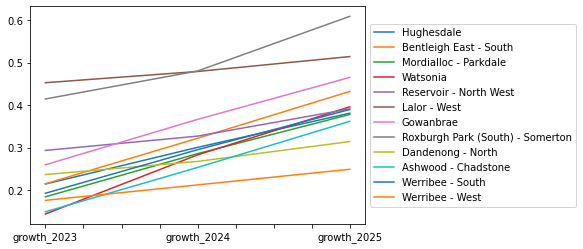

In [69]:
rent_query.transpose().plot.line().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));